# **Brain Stroke Prediction using machine learning**

## Reading dataset and getting global information

In [1]:
# Import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # hides warnings to get proper outputs

In [2]:
# Use pandas to read csv file and show top 5 rows
dir = 'data/full_data.csv'
my_data = pd.read_csv(dir)
my_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [3]:
my_data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## Plotting variables

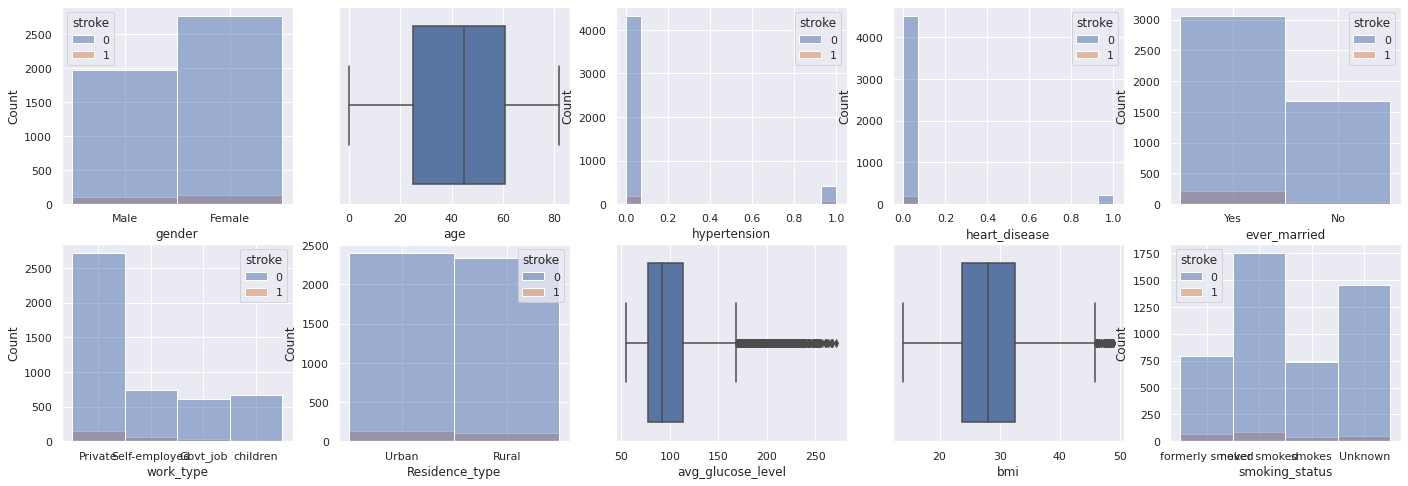

In [4]:
from statistics import mean, median


cont_columns = ['age', 'avg_glucose_level', 'bmi']


# Define a function to plot each variable
def plot(my_data, n_rows, n_cols):
    # my_data: dataset to plot
    # n_rows: number of rows of the graph
    # n_cols: number of columns of the graph
    sns.set()
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 8))

    col = 0
    row = 0
    # col defines the position of the subplot in the graph
    for column in my_data.drop('stroke', axis=1).columns:
        if column in cont_columns:
            sns.boxplot(data=my_data, x=column, hue='stroke', ax=axes[row, col])
        else:
            sns.histplot(data=my_data, x=column, hue='stroke', ax=axes[row, col])
        if (col < n_cols-1):
            col += 1
        else:
            col = 0
            row += 1

plot(my_data, 2, 5)

## Transform categorical variables

As gender, ever_married and Residence_type are binary variables, they will be encoded using label encoder:

In [5]:
from sklearn import preprocessing

data = my_data.copy(deep=True)
columns = ['gender', 'ever_married', 'Residence_type']

# Label Encoder
le = preprocessing.LabelEncoder()

codes = {} # Dict to store tags and values
for column in columns:
    data[column] = le.fit_transform(data[column])
    col = pd.concat([pd.DataFrame(le.classes_, columns=[column]), pd.DataFrame(le.transform(le.classes_), columns=['value'])], axis=1)
    codes[column] = col

On the other hand, work_type and smoking_status will be encoded using OHE:

In [6]:
columns = ['work_type', 'smoking_status']

# OHE
ohe = preprocessing.OneHotEncoder(handle_unknown='ignore', dtype=int)

for column in columns:
    ohe.fit(np.array(data[column]).reshape(-1,1))

    arr = ohe.transform(np.array(data[column]).reshape(-1,1)).toarray()
    df = pd.DataFrame(arr, columns=column+'_'+ohe.categories_[0])

    data = data.drop(columns=[column]).join(df)

    dic = {}
    for i in ohe.categories_[0]:
        dic[i] = ohe.transform([[i]]).toarray()[0]

    codes[column] = dic



Each encoded column has been stored in codes, so we have acces to its values:

In [7]:
pd.DataFrame.from_dict(codes['gender'])

,gender,value
0,Female,0
1,Male,1


In [8]:
pd.DataFrame.from_dict(codes['ever_married'])

,ever_married,value
0,No,0
1,Yes,1


In [9]:
pd.DataFrame.from_dict(codes['Residence_type'])

,Residence_type,value
0,Rural,0
1,Urban,1


In [10]:
pd.DataFrame.from_dict(codes['work_type'], orient='index')

,0,1,2,3
Govt_job,1,0,0,0
Private,0,1,0,0
Self-employed,0,0,1,0
children,0,0,0,1


In [11]:
pd.DataFrame.from_dict(codes['smoking_status'], orient='index')

,0,1,2,3
Unknown,1,0,0,0
formerly smoked,0,1,0,0
never smoked,0,0,1,0
smokes,0,0,0,1


## Finding outliers

The replace outliers function detect and replace outliers values by the column mean or median. For this purpose, we are calculating lower (Q1) and upper (Q3) quartiles, so outliers are out of the range $[Q1-1.5·IQR, Q3*1.5·IQR]$, where $IQR = Q3-Q1$. This is applied iteratively, because, after a replacement, statistics can change and new outliers appear.

In [12]:
import aux

new_data = aux.replace_outliers(data)
new_data.describe()

***Found a total of 0 outliers over 1 iterations.***



,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,0.416382,43.419859,0.096165,0.055210,0.658502,0.508332,105.943562,28.498173,0.049789,0.129291,0.574182,0.161413,0.135113,0.301144,0.174061,0.369002,0.155792
std,0.493008,22.662755,0.294848,0.228412,0.474260,0.499981,45.075373,6.790464,0.217531,0.335556,0.494516,0.367949,0.341879,0.458801,0.379200,0.482583,0.362694
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,55.120000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,77.230000,23.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,45.000000,0.000000,0.000000,1.000000,1.000000,91.850000,28.100000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,1.000000,1.000000,113.860000,32.600000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.740000,48.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Store data

Finally, our data is ready to be stored and used later:

In [13]:
from pathlib import Path  
filepath = Path('data/out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
new_data.to_csv(filepath, index=False)